In [ ]:
import essentia.standard as std
import csv
import glob
import shutil
import sys
from librosa.core import load
import numpy as np
# from librosa.output import write_wav
import soundfile as sf
from scipy import signal
from segmentation import get_beat_sync_chroma_and_spectrum
from utilities import mix_songs
import os


class ShorterException(Exception):
    pass


def mashability(base_beat_sync_chroma, base_beat_sync_spec, audio_file_candidate):
    """
    Calculate the mashability of two songs.
    :param base_beat_sync_chroma: The beat synchronous chroma.
    :param base_beat_sync_spec: The beat synchronous spectrogram.
    :param audio_file_candidate: The path to the candidate for mashability.
    :return: A tuple containing: mashability value, the pitch offset, beat offset.
    """
    try:
        y, sr = load(audio_file_candidate)
    except:
        raise ShorterException("EOF error")
    if len(y)/sr < 3:
        raise ShorterException("Candidate is smaller than 3 seconds")
    # 1st step: Calculate harmonic compatibility
    c_bsc, c_bss = get_beat_sync_chroma_and_spectrum(audio_file_candidate)
    c_bsc = np.flip(c_bsc)  # Flip to make correlation, no convolution
    stacked_beat_sync_chroma = np.vstack([c_bsc, c_bsc])
    conv = signal.convolve2d(stacked_beat_sync_chroma, base_beat_sync_chroma, )
    base_n = np.linalg.norm(base_beat_sync_chroma)
    cand_n = np.linalg.norm(c_bsc)
    h_mas = conv / (base_n * cand_n)
    offset = base_beat_sync_chroma.shape[1]-1
    h_mas = np.flip(h_mas[11:-11, offset:-offset], axis=0)
    h_mas_k = np.max(h_mas, axis=0)  # Maximum mashability for each beat displacement

    # 3rd step: Calculate Spectral balance compatibility
    if c_bss.shape[1] >= base_beat_sync_spec.shape[1]:
        beat_length = base_beat_sync_spec.shape[1]
        n_max_b_shifts = c_bss.shape[1] - base_beat_sync_spec.shape[1]
        r_mas_k = np.zeros(n_max_b_shifts+1)
        for i in range(n_max_b_shifts+1):
            beta = np.mean(base_beat_sync_spec + c_bss[:, i:i + beat_length], axis=1)
            beta_norm = beta/np.sum(beta)
            r_mas_k[i] = 1 - np.std(beta_norm)  # Spectral balance for i beat displacement
    else:
        raise ShorterException("Candidate song has lesser beats than base song")
    res_mash = h_mas_k + 0.2 * r_mas_k
    b_offset = np.argmax(res_mash)
    p_shift = np.argmax(h_mas[:, b_offset])
    if p_shift > 6:
        p_shift = 12 - p_shift

    h_contr = h_mas_k[b_offset]
    r_contr = r_mas_k[b_offset]
    return np.max(res_mash), p_shift, b_offset, h_contr, r_contr


def get_mashability(audio1_vector, audio2_vector, bpm1=None, bpm2=None, sr=44100):
    """
    Takes to audio vectors and calculate the mashability
    :param audio1_vector: Numpy array or similar. Audio of the target excerpt.
    :param audio2_vector: Numpy array or similar. Audio of the candidate excerpt.
    :param sr: Samplerate of the audio. Both audio vectors should have the same samplerate
    :return: A tuple containing: mashability value, the pitch offset, beat offset, harmonic contribution,
    spectral contribution
    """
    c_bsc, c_bss = get_beat_sync_chroma_and_spectrum(audio2_vector, sr=sr, bpm=bpm2)
    base_beat_sync_chroma, base_beat_sync_spec = get_beat_sync_chroma_and_spectrum(audio1_vector, sr=sr, bpm=bpm1)
    c_bsc = np.flip(c_bsc)  # Flip to make correlation, no convolution
    stacked_beat_sync_chroma = np.vstack([c_bsc, c_bsc])
    conv = signal.convolve2d(stacked_beat_sync_chroma, base_beat_sync_chroma, )
    base_n = np.linalg.norm(base_beat_sync_chroma)
    cand_n = np.linalg.norm(c_bsc)
    h_mas = conv / (base_n * cand_n)
    offset = base_beat_sync_chroma.shape[1]-1
    h_mas = np.flip(h_mas[11:-11, offset:-offset], axis=0)
    h_mas_k = np.max(h_mas, axis=0)  # Maximum mashability for each beat displacement

    # 3rd step: Calculate Spectral balance compatibility
    if c_bss.shape[1] >= base_beat_sync_spec.shape[1]:
        beat_length = base_beat_sync_spec.shape[1]
        n_max_b_shifts = c_bss.shape[1] - base_beat_sync_spec.shape[1]
        r_mas_k = np.zeros(n_max_b_shifts+1)
        for i in range(n_max_b_shifts+1):
            beta = np.mean(base_beat_sync_spec + c_bss[:, i:i + beat_length], axis=1)
            beta_norm = beta/np.sum(beta)
            r_mas_k[i] = 1 - np.std(beta_norm)  # Spectral balance for i beat displacement
    else:
        raise ShorterException("Candidate song has lesser beats than base song")
    res_mash = h_mas_k + 0.2 * r_mas_k
    b_offset = np.argmax(res_mash)
    p_shift = np.argmax(h_mas[:, b_offset])
    if p_shift > 6:
        p_shift = 12 - p_shift

    h_contr = h_mas_k[b_offset]
    r_contr = r_mas_k[b_offset]
    return np.max(res_mash), p_shift, b_offset, h_contr, r_contr


def main(base_song=None):
    """
    Main function, takes the name of a song and calculate the mashabilities for each song.
    If -p is used, skip the computation of mashability and goes directly to mix the song
    according to the csv generated during the mashability process.
    """
    if (len(sys.argv)) < 2 and (base_song == None):
        print("Usage: python mashability.py <base_song>")
        return
    else:
        if base_song == None:
            base_song = sys.argv[1]
    if '-p' not in sys.argv:
        base_schroma, base_spec= get_beat_sync_chroma_and_spectrum(base_song)
        songs = glob.glob("%s/*.mp3" % base_song.split('/')[0])  # Search for more mp3 files in the target's directory
        mashabilities = {}
        valid_songs = []
        # Calculate mashability for each of the candidate songs
        # Songs containing less beats than the target one will be discarded
        for cand_song in songs:
            try:
                mashabilities[cand_song] = mashability(base_schroma,
                                                       base_spec,
                                                       cand_song)
                valid_songs.append(cand_song)
            except ShorterException as e:
                print("Skipping song %s, because %s" % (cand_song, str(e)))
        # Sort all songs according to their mashabilities
        valid_songs.sort(key=lambda x: mashabilities[x][0], reverse=True)
        top_10 = valid_songs

        # Write the results of the mashabilities in a csv with the same name as the main loop
        with open(base_song.split('/')[-1].replace('.mp3', '.csv'), 'w') as csvfile:
            csvfile.write("file,mashability,pitch_shift,beat_offset,h_contr,r_contr\n")
            for cand_song in top_10:
                out_file = "out_loops/%s" % (cand_song.split('/')[-1])
                csvfile.write("%s,%s,%s,%s,%s,%s\n" % (out_file, mashabilities[cand_song][0], mashabilities[cand_song][1],
                                                 mashabilities[cand_song][2], mashabilities[cand_song][3], mashabilities[cand_song][4]))


#Baseline Mashability Results:

In [ ]:
import os
import librosa
from scipy.stats import spearmanr

def rank_mashability(root_dir):
    mashability_results = []

    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        audio_path = os.path.join(folder_path, "audio.wav")
        drumnbass_path = os.path.join(folder_path, "drumnbass.wav")

        if os.path.isfile(audio_path) and os.path.isfile(drumnbass_path):
            audio_vector, sr = librosa.load(audio_path, sr=44100)
            drumnbass_vector, sr = librosa.load(drumnbass_path, sr=44100)

            try:
                mash_value, pitch_shift, beat_offset, harmonic_contribution, spectral_contribution = get_mashability(
                    audio_vector, drumnbass_vector, sr=sr
                )
                mashability_results.append((folder_name, mash_value))
            except Exception as e:
                print(f"Error processing {folder_name}: {e}")

    mashability_results.sort(key=lambda x: x[1], reverse=True)

    return mashability_results

def get_label_ratings(root_dir):
    label_ratings = []

    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        label_path = os.path.join(folder_path, "label.txt")

        if os.path.isfile(label_path):
            with open(label_path, 'r') as label_file:
                rating = int(label_file.read().strip())

            label_ratings.append((folder_name, rating))

    label_ratings.sort(key=lambda x: x[1])

    return label_ratings

def calculate_spearman_for_multiple_batches(batch_folders):
    spearman_results = {}

    for root_dir in batch_folders:

        ranked_results = rank_mashability(root_dir)

        label_ratings = get_label_ratings(root_dir)

        ranked_results_dict = {item[0]: item[1] for item in ranked_results}
        label_ratings_dict = {item[0]: item[1] for item in label_ratings}

        common_keys = ranked_results_dict.keys() & label_ratings_dict.keys()
        ranked_results_scores = [ranked_results_dict[key] for key in common_keys]
        label_ratings_ranks = [label_ratings_dict[key] for key in common_keys]

        if len(ranked_results_scores) > 0 and len(label_ratings_ranks) > 0:
            spearman_corr, _ = spearmanr(ranked_results_scores, label_ratings_ranks)
            spearman_results[root_dir] = spearman_corr
        else:
            spearman_results[root_dir] = None
            print(f"Warning: No valid data to calculate Spearman correlation for {root_dir}")

    return spearman_results

batch_folders = [
    "drive/MyDrive/80_batches_mod/batch_12/",
    "drive/MyDrive/80_batches_mod/batch_32/",
    "drive/MyDrive/80_batches_mod/batch_52/",
    "drive/MyDrive/80_batches_mod/batch_72/"
]

spearman_results = calculate_spearman_for_multiple_batches(batch_folders)

for batch, corr in spearman_results.items():
    print(f"Batch: {batch}, Spearman Correlation: {corr}")



Processing batch: drive/MyDrive/80_batches_mod/batch_12/
Processing batch: drive/MyDrive/80_batches_mod/batch_32/
Processing batch: drive/MyDrive/80_batches_mod/batch_52/
Processing batch: drive/MyDrive/80_batches_mod/batch_72/
Batch: drive/MyDrive/80_batches_mod/batch_12/, Spearman Correlation: -0.6
Batch: drive/MyDrive/80_batches_mod/batch_32/, Spearman Correlation: 0.39999999999999997
Batch: drive/MyDrive/80_batches_mod/batch_52/, Spearman Correlation: -0.3
Batch: drive/MyDrive/80_batches_mod/batch_72/, Spearman Correlation: 0.8999999999999998


#Mashability on all sets


In [ ]:
import os
import librosa
from scipy.stats import spearmanr
import numpy as np

# Function to calculate mashability for each folder
def rank_mashability(root_dir):
    mashability_results = []

    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        audio_path = os.path.join(folder_path, "audio.wav")
        drumnbass_path = os.path.join(folder_path, "drumnbass.wav")

        if os.path.isfile(audio_path) and os.path.isfile(drumnbass_path):
            audio_vector, sr = librosa.load(audio_path, sr=44100)
            drumnbass_vector, sr = librosa.load(drumnbass_path, sr=44100)

            try:
                mash_value, pitch_shift, beat_offset, harmonic_contribution, spectral_contribution = get_mashability(
                    audio_vector, drumnbass_vector, sr=sr
                )
                mashability_results.append((folder_name, mash_value))
            except Exception as e:
                print(f"Error processing {folder_name}: {e}")

    mashability_results.sort(key=lambda x: x[1], reverse=True)

    return mashability_results

def get_label_ratings(root_dir):
    label_ratings = []

    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        label_path = os.path.join(folder_path, "label.txt")

        if os.path.isfile(label_path):
            with open(label_path, 'r') as label_file:
                rating = int(label_file.read().strip())

            label_ratings.append((folder_name, rating))

    label_ratings.sort(key=lambda x: x[1])

    return label_ratings

def calculate_spearman_for_multiple_batches(parent_dir):
    spearman_results = []

    for folder_name in os.listdir(parent_dir):
        root_dir = os.path.join(parent_dir, folder_name)
        if os.path.isdir(root_dir):
            print(f"Processing batch: {root_dir}")

            ranked_results = rank_mashability(root_dir)

            label_ratings = get_label_ratings(root_dir)

            ranked_results_dict = {item[0]: item[1] for item in ranked_results}
            label_ratings_dict = {item[0]: item[1] for item in label_ratings}

            common_keys = ranked_results_dict.keys() & label_ratings_dict.keys()
            ranked_results_scores = [ranked_results_dict[key] for key in common_keys]
            label_ratings_ranks = [label_ratings_dict[key] for key in common_keys]

            if len(ranked_results_scores) > 0 and len(label_ratings_ranks) > 0:
                spearman_corr, _ = spearmanr(ranked_results_scores, label_ratings_ranks)
                spearman_results.append(spearman_corr)
            else:
                print(f"Warning: No valid data to calculate Spearman correlation for {root_dir}")

    if len(spearman_results) > 0:
        mean_spearman_corr = np.mean(spearman_results)
        print(f"Mean Spearman Correlation: {mean_spearman_corr}")
    else:
        mean_spearman_corr = None
        print("No valid correlations found.")

    return mean_spearman_corr, spearman_results

parent_dir = "drive/MyDrive/80_batches_mod/"

mean_spearman_corr, spearman_results = calculate_spearman_for_multiple_batches(parent_dir)

for i, corr in enumerate(spearman_results):
    print(f"Batch {i + 1}: Spearman Correlation = {corr}")


Processing batch: drive/MyDrive/80_batches_mod/batch_12
Processing batch: drive/MyDrive/80_batches_mod/batch_80
Processing batch: drive/MyDrive/80_batches_mod/batch_78
Error processing label_drumbass_circles_betterdays: Candidate song has lesser beats than base song
Error processing label_drumbass_circles_blindinglights: Candidate song has lesser beats than base song
Error processing label_drumbass_circles_body: Candidate song has lesser beats than base song
Error processing label_drumbass_circles_asitwas: Candidate song has lesser beats than base song
Error processing label_drumbass_circles_badhabit: Candidate song has lesser beats than base song
Processing batch: drive/MyDrive/80_batches_mod/batch_76
Processing batch: drive/MyDrive/80_batches_mod/batch_74
Processing batch: drive/MyDrive/80_batches_mod/batch_72
Processing batch: drive/MyDrive/80_batches_mod/batch_70
Error processing label_drumbass_betterdays_blindinglights: Candidate song has lesser beats than base song
Error processi

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=902
  warnings.warn(


Processing batch: drive/MyDrive/80_batches_mod/batch_54
Processing batch: drive/MyDrive/80_batches_mod/batch_52
Processing batch: drive/MyDrive/80_batches_mod/batch_44
Processing batch: drive/MyDrive/80_batches_mod/batch_42
Processing batch: drive/MyDrive/80_batches_mod/batch_55
Mean Spearman Correlation: 0.10411827863213917
Batch 1: Spearman Correlation = -0.6
Batch 2: Spearman Correlation = 0.3
Batch 3: Spearman Correlation = 0.7
Batch 4: Spearman Correlation = 0.15389675281277312
Batch 5: Spearman Correlation = 0.8999999999999998
Batch 6: Spearman Correlation = 1.0
Batch 7: Spearman Correlation = -0.3
Batch 8: Spearman Correlation = 0.19999999999999998
Batch 9: Spearman Correlation = -0.46169025843831935
Batch 10: Spearman Correlation = 0.8999999999999998
Batch 11: Spearman Correlation = -0.6
Batch 12: Spearman Correlation = -0.19999999999999998
Batch 13: Spearman Correlation = -0.09999999999999999
Batch 14: Spearman Correlation = -0.19999999999999998
Batch 15: Spearman Correlation 

In [ ]:
from torch import nn

#Neural loop combiner

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)

class Skeleton(nn.Module):
    def __init__(self):
        super(Skeleton, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                                  nn.Dropout(0.1),
                                  nn.BatchNorm2d(16),
                                  nn.PReLU(),
                                  nn.Conv2d(16, 4, 3, padding=1),
                                  nn.Dropout(0.1),
                                  nn.BatchNorm2d(4),
                                  nn.PReLU())

        self.fc = nn.Sequential(nn.Linear(564736, 256),
                                nn.BatchNorm1d(256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.BatchNorm1d(128),
                                nn.PReLU(),
                                nn.Linear(128, 16))

        self.apply(init_weights)

    def forward(self, x):
        output = self.conv(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class CNN(nn.Module):
    def __init__(self, skeleton):
        super(CNN, self).__init__()
        self.conv = skeleton.conv
        self.fc   = nn.Sequential(skeleton.fc,
                                  nn.BatchNorm1d(16),
                                  nn.PReLU(),
                                  nn.Linear(16, 1),
                                  nn.Sigmoid())
        self.apply(init_weights)


    def forward(self, x):
        output = self.conv(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class SNN(nn.Module):
    def __init__(self, skeleton):
        super(SNN, self).__init__()
        self.conv = skeleton.conv
        self.fc   = skeleton.fc
        self.apply(init_weights)

    def forward_once(self, x):
        output = self.conv(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2




Training set size: 74
Validation set size: 20
Epoch [1/50], Training Loss: 5.6488
Epoch [1/50], Validation Loss: 1.8889
Model saved at models/model_epoch_1.pth
Epoch [2/50], Training Loss: 7.0886
Epoch [2/50], Validation Loss: 0.3152
Model saved at models/model_epoch_2.pth
Epoch [3/50], Training Loss: 3.4621
Epoch [3/50], Validation Loss: 0.1883
Model saved at models/model_epoch_3.pth
Epoch [4/50], Training Loss: 1.4605
Epoch [4/50], Validation Loss: 0.2376
Model saved at models/model_epoch_4.pth
Epoch [5/50], Training Loss: 1.2976
Epoch [5/50], Validation Loss: 0.1488
Model saved at models/model_epoch_5.pth
Epoch [6/50], Training Loss: 0.8844
Epoch [6/50], Validation Loss: 0.1294
Model saved at models/model_epoch_6.pth
Epoch [7/50], Training Loss: 0.8228
Epoch [7/50], Validation Loss: 0.1371
Model saved at models/model_epoch_7.pth
Epoch [8/50], Training Loss: 0.5361
Epoch [8/50], Validation Loss: 0.1275
Model saved at models/model_epoch_8.pth
Epoch [9/50], Training Loss: 0.4911
Epoch 

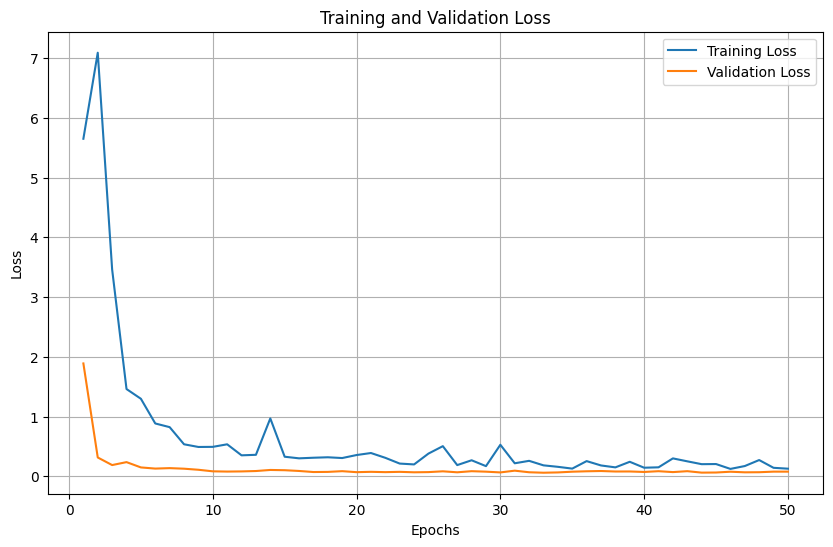

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        distances = torch.pow(F.pairwise_distance(output1, output2), 2)
        losses = 0.5 * (target.float() * distances +
                        (1 - target).float() * F.relu(self.margin - torch.sqrt(distances + 1e-9)).pow(2))
        return losses.mean()

import os

import matplotlib.pyplot as plt
import os

def train_snn(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=20, save_dir='models'):
    model.to(device)
    plot_losses(train_losses, val_losses)

def evaluate_snn(model, val_loader, loss_fn, device):
    model.eval()
    running_val_loss = 0.0

    return running_val_loss / len(val_loader)


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.savefig('loss_plot.png')
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 50
batch_size = 8
learning_rate = 0.001

skeleton = Skeleton()
snn_model = SNN(skeleton)

contrastive_loss = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(snn_model.parameters(), lr=learning_rate)

train_loader, val_loader = create_dataloaders('drive/MyDrive/correct_snn', 'drive/MyDrive/wrong_snn', batch_size=8)

train_snn(snn_model, train_loader, val_loader, contrastive_loss, optimizer, device, epochs)



In [ ]:
import os
import torch
import torchaudio
from scipy.stats import spearmanr

def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def evaluate_folders(model, base_dir, device, sample_rate=44100, n_mels=128):
    model.eval()
    compatibility_scores = []
    labels = []

    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

    with torch.no_grad():
        for folder_name in sorted(os.listdir(base_dir)):
            folder_path = os.path.join(base_dir, folder_name)
            files = sorted([f for f in os.listdir(folder_path) if f.endswith('.wav')])
            label_file = os.path.join(folder_path, 'label.txt')

            with open(label_file, 'r') as f:
                label = float(f.read().strip())
                labels.append(label)

            wav1, _ = torchaudio.load(os.path.join(folder_path, files[0]))
            wav2, _ = torchaudio.load(os.path.join(folder_path, files[1]))

            if wav1.size(0) > 1:
                wav1 = torch.mean(wav1, dim=0, keepdim=True)
            if wav2.size(0) > 1:
                wav2 = torch.mean(wav2, dim=0, keepdim=True)

            mel1 = mel_transform(wav1)
            mel2 = mel_transform(wav2)

            mel1, mel2 = mel1.to(device), mel2.to(device)

            output1, output2 = model(mel1.unsqueeze(0), mel2.unsqueeze(0))

            distance = torch.nn.functional.pairwise_distance(output1, output2)
            # lower score means smaller distance between, better fit
            compatibility_scores.append(-distance.item())

    return compatibility_scores, labels

def compute_spearman_correlation(compatibility_scores, labels):
    correlation, _ = spearmanr(compatibility_scores, labels)
    return correlation

skeleton = Skeleton()
snn_model = SNN(skeleton)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'models/model_epoch_33.pth'
snn_model = load_model(snn_model, model_path, device)

base_dir = 'drive/MyDrive/80_batches_mod/batch_12/'

compatibility_scores, labels = evaluate_folders(snn_model, base_dir, device)

spearman_correlation = compute_spearman_correlation(compatibility_scores, labels)

print("Compatibility Scores for Folders:")
for i, (score, label) in enumerate(zip(compatibility_scores, labels)):
    print(f"Folder {i+1}: Compatibility Score = {score:.4f}, Label = {label:.4f}")

print(f"Spearman Rank Correlation: {spearman_correlation:.4f}")


<ipython-input-18-1d864a92f90a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Compatibility Scores for Folders:
Folder 1: Compatibility Score = -0.9667, Label = 4.0000
Folder 2: Compatibility Score = -1.1657, Label = 3.0000
Folder 3: Compatibility Score = -1.1478, Label = 5.0000
Folder 4: Compatibility Score = -2.6605, Label = 9.0000
Folder 5: Compatibility Score = -1.0220, Label = 2.0000
Spearman Rank Correlation: -0.5000
